# Analysis of results

In [1]:
import random
import cv2
import numpy as np
import torch
import torchvision.transforms.functional as TF
import pandas as pd
from torchvision.transforms import transforms
from model import UNetWithResnet50Encoder
from backboned_unet import Unet
import PIL
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

plt.style.use("ggplot")

## train + test loss functions

In [2]:
df_densenet161 = pd.read_csv('logger-densenet161.csv')
df_resnet101 = pd.read_csv('logger-resnet101.csv')
df_resnet50 = pd.read_csv('logger-resnet50.csv')

0.026080895


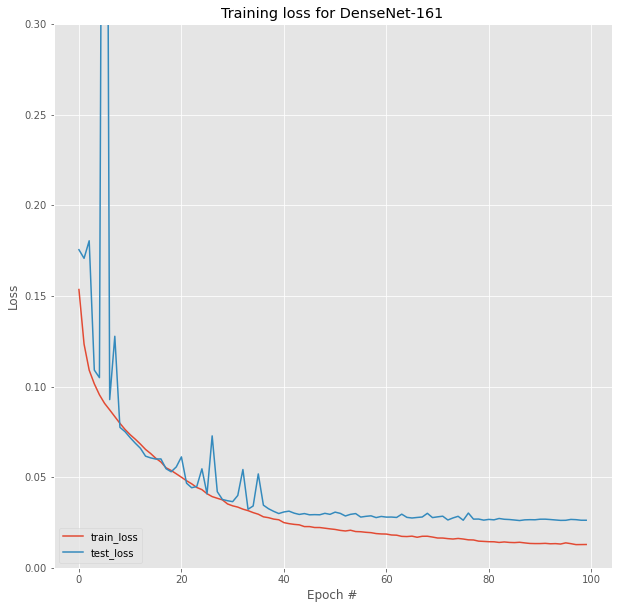

In [3]:
plt.figure(figsize=(10, 10))
plt.plot(df_densenet161["train"], label="train_loss")
plt.plot(df_densenet161["test"], label="test_loss")
plt.ylim(0, 0.3)
plt.title("Training loss for DenseNet-161")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
print(min(df_densenet161["test"]))

0.02966741


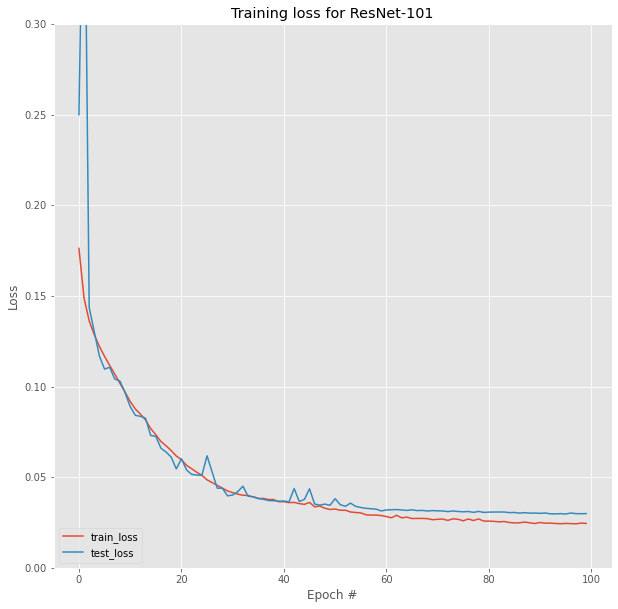

In [4]:
plt.figure(figsize=(10, 10))
plt.plot(df_resnet101["train"], label="train_loss")
plt.plot(df_resnet101["test"], label="test_loss")
plt.ylim(0, 0.3)
plt.title("Training loss for ResNet-101")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
print(min(df_resnet101["test"]))

0.03128504


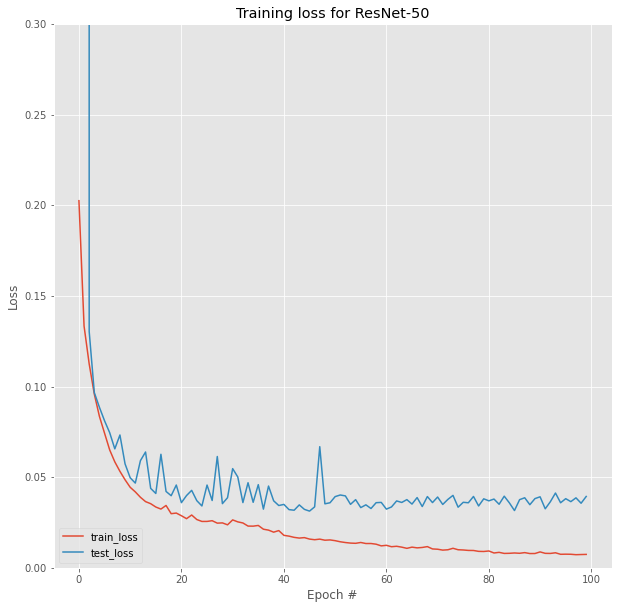

In [5]:
plt.figure(figsize=(10, 10))
plt.plot(df_resnet50["train"], label="train_loss")
plt.plot(df_resnet50["test"], label="test_loss")
plt.ylim(0, 0.3)
plt.title("Training loss for ResNet-50")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
print(min(df_resnet50["test"]))

## Evaluating proposed masks

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [15]:
# Load all nets
loaded_densenet161 = torch.load('model-densenet161.pth', map_location=torch.device(device))
loaded_resnet101 = torch.load('model-resnet101.pth', map_location=torch.device(device))
loaded_resnet50 = torch.load('model-resnet50.pth', map_location=torch.device(device))

# Initialize models
unet_densenet161 = Unet(backbone_name='densenet161', classes=1).to(device)
unet_resnet101 = Unet(backbone_name='resnet101', classes=1).to(device)
unet_resnet50 = UNetWithResnet50Encoder().to(device)

# and update their params
unet_densenet161.load_state_dict(loaded_densenet161['net_state'])
unet_resnet101.load_state_dict(loaded_resnet101['net_state'])
unet_resnet50.load_state_dict(loaded_resnet50['net_state'])

unet_densenet161.eval()
unet_resnet101.eval()
unet_resnet50.eval()

del loaded_resnet50
del loaded_resnet101
del loaded_densenet161

C:\Users\KUBA\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\KUBA\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


upsample_blocks[0] in: 2208   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


C:\Users\KUBA\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


upsample_blocks[0] in: 2048   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


C:\Users\KUBA\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


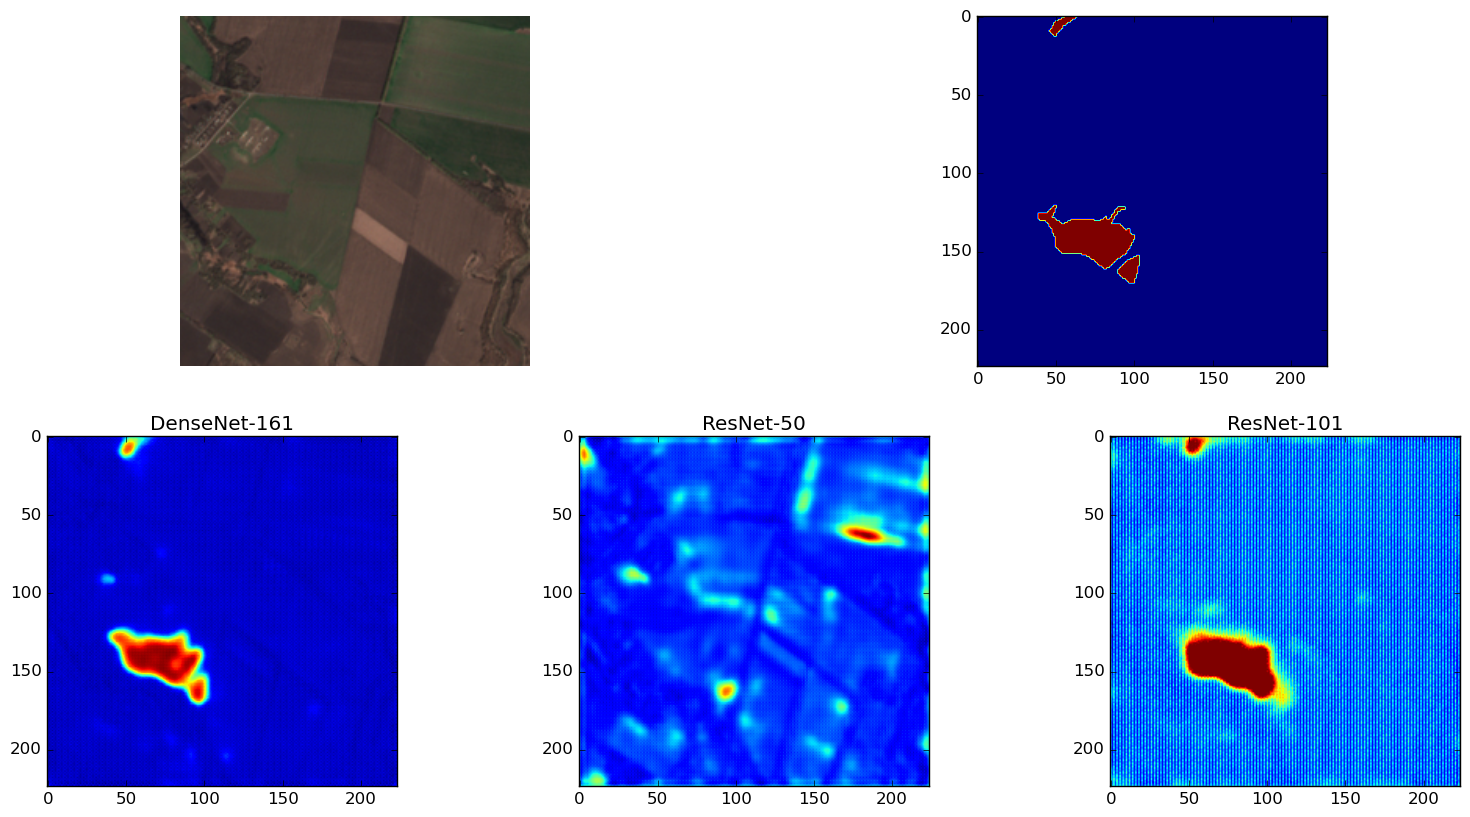

In [28]:
# Get location of desired photo by id
i = 5
data_df = pd.read_csv('data/data.csv')
image_path = data_df['img_location'][i]
mask_path = data_df['mask_location'][i]

# Open image + mask and normalize them
image = cv2.imread(str(image_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = (image / 255.0).astype('float32')
mask = (cv2.imread(str(mask_path), 0))

# Numpy's array to PyTorch's tensor
transform = transforms.ToTensor()
image = transform(image)

# Models' predictions
with torch.no_grad():
    # Get predictions for each model
    pred_unet_densenet161 = unet_densenet161(torch.clone(image).unsqueeze(0))
    pred_unet_resnet101 = unet_resnet101(torch.clone(image).unsqueeze(0))
    pred_unet_resnet50 = unet_resnet50(torch.clone(image).unsqueeze(0))

    # Plot everything
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 6)
    plt.rcdefaults()
    with plt.style.context('classic'):
        # Plot Image
        ax1 = fig.add_subplot(gs[0, :3])
        ax1.imshow(PIL.Image.open(str(image_path)))
        ax1.axis('off')
        # Plot original mask
        ax2 = fig.add_subplot(gs[0, 3:])
        ax2.imshow(mask)
        # Plot prediction mask from DenseNet-161
        ax3 = fig.add_subplot(gs[1, :2])
        ax3.imshow(pred_unet_densenet161.squeeze())
        ax3.set_title('DenseNet-161')
        # Plot prediction mask from ResNet-101
        ax4 = fig.add_subplot(gs[1, 4:])
        ax4.imshow(pred_unet_resnet101.squeeze())
        ax4.set_title('ResNet-101')
        # Plot prediction mask from ResNet-50
        ax5 = fig.add_subplot(gs[1, 2:4])
        ax5.imshow(pred_unet_resnet50.squeeze())
        ax5.set_title('ResNet-50')

        plt.show()